In [1]:
%%capture
!pip install --upgrade pip
!pip install tensorflow numpy==1.16 sklearn matplotlib

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
corpus_raw = 'He is the king . The king is royal . She is the royal queen '
corpus_raw = corpus_raw.lower()

In [4]:

words = []
words = corpus_raw.split()
# parse through the corpus and remove the dots
words = [word.strip('。') for word in words]


# Convert words into integers and vice versa
word2int = {}
int2word = {}
vocab_size = len(words)

for i, word in enumerate(words):
    # TODO 1: Fill in the logic for word2int and int2word mappings
    # for example: word_to_int has words as keys and integers as value
     if word not in word2int:
        # Assign a unique integer to each word
        word2int[word] = i
        int2word[i] = word

In [5]:
# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

In [6]:
WINDOW_SIZE = 2
data = []
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] :
            if nb_word != word:
                data.append([word, nb_word])

### ***What does the previous cell do ?***
* ***Your** thoughts here*
This code block processes the raw text data, labels it as sentences and words, and then creates word pairs where one word is the target word and the other is the context word

In [7]:

def to_one_hot(data_point_index, vocab_size):
    # TODO 2: Implement the one-hot encoding function here.
    # initialize a list of zeros equal to vocab_size
    # turn this list into a one hot vector for the data_point_index
    one_hot_vector = [0] * vocab_size
    one_hot_vector[data_point_index] = 1

    return one_hot_vector

In [8]:

x_train = [] # input words
y_train = [] # output words

for data_word in data:
    # TODO 3: Append appropriate one-hot encoded vectors to x_train and y_train
    target_word, context_word = data_word[0], data_word[1]
    x_train.append(to_one_hot(word2int[context_word], vocab_size))
    y_train.append(to_one_hot(word2int[target_word], vocab_size))

In [9]:

# Convert lists to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x = tf.placeholder(tf.float32, shape=(None, vocab_size))
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

### ***What does the previous cell do ?***
* ***Your** thoughts here*
This code prepares training data by converting word pairs into solo thermal encoding vectors, making it suitable for training a word-skipping word embedding model. The model learns to predict context words from the target word and is typically used to generate word embeddings that capture semantic relationships between words.

In [10]:

EMBEDDING_DIM = 5

# TODO 5: Initialize weight matrices W1 and W2 with random values, and biases b1 and b2.
# Use tf.Variable and tf.random_normal with the appropriate shapes to initialize layers and biases
# look at the slides if you don't remember the layer shapes

W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM], stddev=0.01))
b1 = tf.Variable(tf.zeros([EMBEDDING_DIM]))
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size], stddev=0.01))
b2 = tf.Variable(tf.zeros([vocab_size]))

In [11]:

# TODO 6: Calculate the hidden representation of the word.
# "hidden representation" means the value of the vector after the first layer
# i.e. the vector within the latent space of the network
# use tf.add and tf.matmul

hidden_representation = tf.add(tf.matmul(x, W1), b1)

In [12]:

# TODO 7: Compute the prediction, the output from the output layer.
# hint: the prediction follows is the hidden representation passed through the second layer
# don't forget to add the softmax to turn the outputs into a probability distribution
# you may use tf.nn.softmax for that
output_layer_input = tf.add(tf.matmul(hidden_representation, W2), b2)
prediction = tf.nn.softmax(output_layer_input)

In [13]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### ***What does the previous cell do ?***
* ***Your** thoughts here*
This code prepares the input placeholders for the neural network and computes the hidden representation of the word by linearly transforming the input x with the weight matrix W1 and the bias vector b1.

In [14]:
# Define the loss function:
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))

### ***Which loss function is this ?***
* ***Your** thoughts here*<br>
The loss function is the cross-entropy loss, specifically the categorical cross-entropy loss.

### ***Why do we use it here ?***
* ***Your** thoughts here*<br>
Cross entropy loss is commonly used in classification tasks because it measures the difference between the predicted probability distribution and the true distribution (uniquely thermally encoded labels). Cross-entropy loss has favourable properties for gradient-based optimisation: it imposes heavier penalties when the predicted probabilities differ significantly from the true values. This encourages the model to adjust its parameters to improve the prediction, which is important for training accurate word embeddings.

In [15]:

# Define the training step:
# TODO 10: Use an optimizer to minimize the loss.
# look through the documentation:
# https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/GradientDescentOptimizer
# tf.compat.v1 is replaced with tf in our code

learning_rate = 0.01
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [16]:

n_iters = 10000

for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})

vectors = sess.run(W1 + b1)

### ***Reminder***

Euclidian distance:
$$ ||x-y||_2 = \sqrt{ \sum_{i=1}^{N} (x_i - y_i)^2 } $$

In [17]:
# TODO 11 (last one!): implement the euclidian distance function using numpy
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

### ***What is TSNE ? How is it useful here ?***
* ***Your** thoughts here*<br>
The t-SNE can downscale high-dimensional data to a lower dimensional space. In natural language processing, word embeddings are usually high-dimensional, and t-SNE can downscale them to two or three dimensions for visualisation and analysis


In [18]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, perplexity=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

print(vectors)

[[ 0.8276927  -0.56118166]
 [-0.920084   -0.39172107]
 [-0.9541064   0.2994679 ]
 [ 0.807574   -0.5897664 ]
 [-0.99044746 -0.13789026]
 [-0.9973796   0.07234559]
 [-0.9654423  -0.26061684]
 [-0.99773425 -0.06727757]
 [-0.9966516   0.08176548]
 [-0.99238324 -0.12318914]
 [ 0.82616997 -0.56342095]
 [-0.90550464 -0.4243363 ]
 [-0.9890964  -0.1472699 ]
 [-0.97962356  0.20084254]
 [-0.9541648  -0.29928157]]


['he', 'is', 'the', 'king', '.', 'the', 'king', 'is', 'royal', '.', 'she', 'is', 'the', 'royal', 'queen']
he -0.56118166
is -0.39172107
the 0.2994679
king -0.5897664
. -0.13789026
the 0.2994679
king -0.5897664
is -0.39172107
royal 0.08176548
. -0.13789026
she -0.56342095
is -0.39172107
the 0.2994679
royal 0.08176548
queen -0.29928157


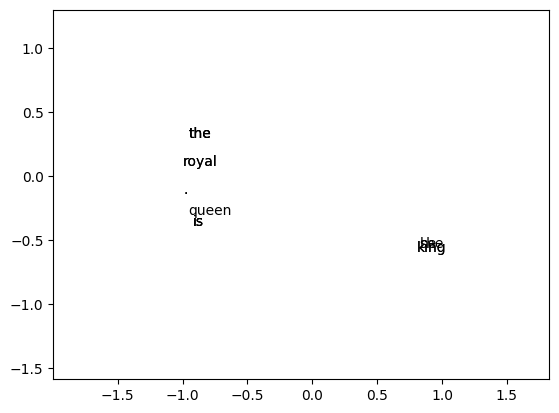

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
print(words)
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
    ax.set_xlim(min([vectors[word2int[w]][0] for w in words])-1, max([vectors[word2int[w]][0] for w in words])+1)
    ax.set_ylim(min([vectors[word2int[w]][1] for w in words])-1, max([vectors[word2int[w]][1] for w in words])+1)
plt.show()

### ***You should see something similar:***
<img src="word_2_vec_result.png">

### ***Comment on what you've understood from this course***
For example:
* What is word2vec ? <br>
The goal of Word2Vec is to capture the semantic relationships between words by representing each word as a dense set of vectors of real numbers.
* Why is it an improvement on BoW and TF-IDF <br>
Word2Vec takes into account the context in which words appear, allowing subtle semantic relationships to be captured.BoW and TF-IDF treat all words as independent features.Word2Vec embeddings can be used to compute word similarity, which is not directly feasible in BoW or TF-IDF.
* What is an encoder network, can you imagine an example to illustrate this notion ?<br>
Let's consider an example of an image autoencoder:
Input: a greyscale image (e.g., 28x28 pixels).
Encoder network: the encoder network consists of a convolutional layer followed by a fully connected layer. It takes the image as input and learns to map it to low-dimensional vectors that are usually much smaller than the original image size (encoding).
Decoder network: the decoder network accepts the encoding and reconstructs the original image from it. It contains layers for upsampling and convolution operations.
Goal: During training, the goal of the autoencoder is to minimise the reconstruction error and ensure that the decoder output is as close as possible to the input image.<br>
Encoder networks play a key role in compressing information from an input image into a compact representation, which is useful for tasks such as image denoising, dimensionality reduction or feature extraction.